# Dynamic communicability and flow: principles and basic examples

<br/>

This notebook is an introductory tutorial for the use of dynamic communicability and flow to study complex networks.

#### Outline
* DynComFlow library installation and overview
* Overview of basic concepts. 
* Example-1: Path graphs.
* Example-2: Ring-lattice and randomization.

----------

### Dependencies

The tutorial requires a Python 3.X installation together with NumPy and Matplotlib libraries. It also requires further in-house modules. [GAlib](https://github.com/gorkazl/pyGAlib) is a generic library for graph analysis; and [NetDynFlow](https://github.com/gorkazl/NetDynFlow) to estimate and study dynamic communicability and flow, and to perform the model-based temporal network analysis.
<font color='red'>
GORKA: _We can remove the GAlib dependency if you want to. For these simple networks we could just generate the adjacency matrices on site._
</font>

#### Import the main libraries

To get started, the first thing we need is to load the libraries we will need to work. Start importing the built-in and third party libraries.


In [1]:
from __future__ import division, print_function

from timeit import default_timer as timer
#import matplotlib.pyplot as plt
import matplotlib.pyplot as pp
%matplotlib inline
import numpy as np
import numpy.linalg


#### Import personal libraries

The following cells will check whether *GAlib* and *NetDynFlow* are already installed in the current working environment, otherwise, `pip` will be called for the installation (a working internet connection is required). **NOTE**: The exclamation mark ( ! ) before ``pip install galib`` indicates to the Jupyter Notebook that the current line is a system command, which is then treated as if it were run from a terminal.


In [2]:
## Check if GAlib is installed in the current environment, otherwise install
try:
    import galib
except:
    # Install from PyPI
    print('Installing GAlib...')
    ! pip install galib
    import galib

In [3]:
import galib.models
import galib.tools

In [4]:
## Check if NetDynFlow is installed in the current environment, otherwise install
try:
    import netdynflow
except:
    # Install from the GitHub repository
    print('Installing NetDynFlow...')
    #! pip install git+https://github.com/mb-BCA/NetDynFlow.git@master
    ! pip install git+https://github.com/mb-BCA/NetDynFlow.git@version2

import netdynflow as ndf

In [ ]:
# Explore the help functions of NetDynFlow
# ndf?
# ndf.core?
# ndf.metrics?

<br/>

## Overview of basic concepts

The aim of this framework is to extract information on a network's structure by exploring how perturbations propagate along it. Every node is assumed to behave as a linear Ornstein-Uhlenbeck process fed by Gaussian noise. Given that $A$ is the connectivity matrix (weighted or unweighted, directed or undirected) the dynamics of a node follows: 

$\dot{x}_i = - \frac{x_i}{\tau} + \sum_{j=1}^N x_j + \xi_i $

where $\xi_i$ is a Gaussian white noise, independent at each node.

<font color='red'>
CONTINUE FROM HERE WITH A BRIEF SUMMARY OF THE MEANING OF THE DYNAMIC FLOW AND DYNAMIC COMMUNICABILITY AS AN SPECIAL CASE OF THE FLOW.
</font>


… quantifies the interactions between nodes over time (via the Green function). There are 4 points 
that can be seen in the following examples:
    - communicability captures the global network feedback
    - node-wise measures of input and output communicability capture their listening and broadcasting nature while taking network effects into account
    - nodes without direct connections may have non-zero interactions because of network effects for xxx integration time
    - the communicability matrix is first aligned with weights, then becomes homogeneous


For further reference and citation, see:

- M. Gilson, N. Kouvaris, G. Deco and G. Zamora-Lopez "*[Framework based on communicability and flow to analyze complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.97.052301)*" Phys. Rev. E **97**, 052301 (2018).
- M. Gilson, N. Kouvaris, et al. "*[Network analysis of whole-brain fMRI dynamics: A new framework based on dynamic communicability](https://doi.org/10.1016/j.neuroimage.2019.116007)*" NeuroImage **201**, 116007 (2019).



<br/>

## Example 1: First steps, a directed path

### Dynamic flow
We start by studying the flow and dynamic communicability on very simple graphs in order to understand the basic concepts. As a simple example we consider chain graphs as the one with directed arcs as in the figure below. We characterise how the perturbation applied to the first node propagates along the chain.

<img src="Images/PathGraph_Directed1.pdf" style="float:center; width:500px; height:50px"  alt="Path Graph" />

First, we create the network and estimate its spectral radius in order to identify the largest time-constant τ we can apply to the leakage term so that the network dynamics are convergent.

In [5]:
# Create a directed path graph of N = 6 nodes
N = 6
dirnet = galib.models.PathGraph(N, directed=True)

# Find the spectral radius and the largest time constant 
evs = numpy.linalg.eigvals(dirnet)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:', evmax )
print( 'Largest possible tau:', maxtau)

Spectral radius: 0.0
Largest possible tau: inf


/Users/gorka/Library/Enthought/Canopy/edm/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


To cause a flow we need to _**set an external perturbation**_. Therefore, the matrix `sigma` is defined, which encodes the covariances between the external Gaussian noisy inputs. Since here we only want to excite the first node, `sigma` will be all zeros exept for its `[0,0]` element.

In [6]:
# Set the matrix of noisy inputs
sigma = np.zeros((N,N), np.float)
sigma[0,0] = 1.0

# Set a time-constant
tau = 1.0

# Define the temporal resolution for the "simulation"
tfinal = 10
dt = 0.01
tpoints = np.arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the dynamic flow for a time span between 0 and tmax
fullflow_dir = ndf.FullFlow(dirnet, tau, sigma, tmax=tfinal, timestep=dt, normed=True)
dynflow_dir = ndf.DynFlow(dirnet, tau, sigma, tmax=tfinal, timestep=dt, normed=True) 

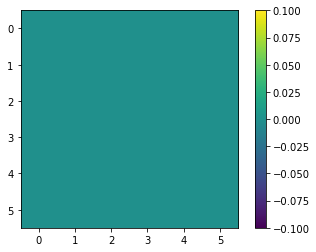

In [10]:
# Visualise the flow matrices at different times
pp.figure()
# Check for (temporal) indices: 0, 100, 200, 400, 600, 800
#pp.imshow(fullflow_dir[600])
pp.imshow(dynflow_dir[0])
pp.colorbar()
pp.show()

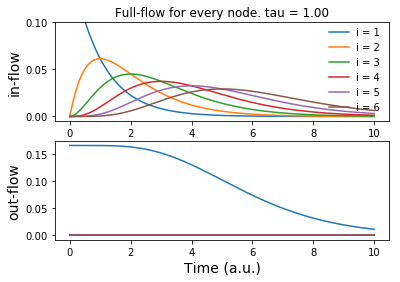

In [11]:
# Calculate the in-/out- full-flow for every node
# infullflow and outfullflow are two arrays of shape (N,nsteps)
infullflow_dir, outfullflow_dir = ndf.NodeEvolution(fullflow_dir)

# Plot a figure wit the input and output flows of every node
pp.figure()
pp.subplot(2,1,1)
pp.title('Full-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    pp.plot(tpoints, infullflow_dir[:,i], label='i = %d' %(i+1))
pp.ylim(-0.005,0.1)
pp.ylabel('in-flow', fontsize=14)
pp.legend(frameon=False)

pp.subplot(2,1,2)
for i in range(N):
    pp.plot(tpoints, outfullflow_dir[:,i], label='i = %d' %(i+1))
pp.ylabel('out-flow', fontsize=14)
pp.xlabel('Time (a.u.)', fontsize=14)

pp.show()

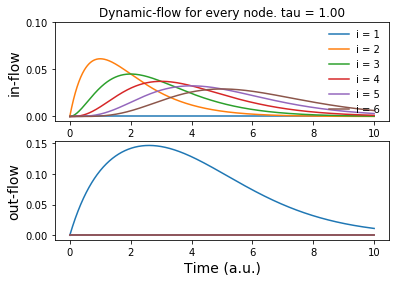

In [12]:
# Calculate the in-/out- dynamic-flow for every node
# inflow and outflow are two arrays of shape (N,nsteps)
inflow_dir, outflow_dir = ndf.NodeEvolution(dynflow_dir)

# Plot the input and output full-flow of every node
pp.figure()
pp.subplot(2,1,1)
pp.title('Dynamic-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    pp.plot(tpoints, inflow_dir[:,i], label='i = %d' %(i+1))
pp.ylim(-0.005,0.1)
pp.ylabel('in-flow', fontsize=14)
pp.legend(loc='center right', frameon=False)

pp.subplot(2,1,2)
for i in range(N):
    pp.plot(tpoints, outflow_dir[:,i], label='i = %d' %(i+1))
pp.ylabel('out-flow', fontsize=14)
pp.xlabel('Time (a.u.)', fontsize=14)

pp.show()

#### Dynamic communicability

The concept of flow is very general since it doesn't make any specific assumptions on which nodes are excited, and it even accepts the excitation of several nodes by correlated noise. That would be encoded by the extra-diagonal entries in the *sigma* matrix. For a generic and comparable method to study different networks, we name *dynamic communicability* to the special case of the flow in which every node is perturbed by independent Gaussian noise of the same variance. The idea is illustrated as follows:

<img src="Images/PathGraph_Directed2.pdf" style="float:center; width:500px; height:50px"  alt="Path Graph" />

In this case, the *sigma* matrix is represented as the unit matrix **1**. Thus, notice that function `netdynflow.DynCom()` does not require `sigma` as an explicit input.

In [13]:
# Calculate the dynamic communicability for a time span between 0 and tmax
dyncom_dir = ndf.DynCom(dirnet, tau, tmax=tfinal, timestep=dt, normed=True)

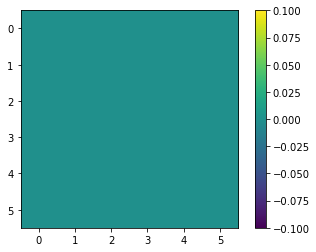

In [16]:
# Visualise the dynamic communicability matrices at different times
pp.figure()
# Check for (temporal) indices: 0, 100, 200, 400, 600, 800
pp.imshow(dyncom_dir[0])
pp.colorbar()
pp.show()

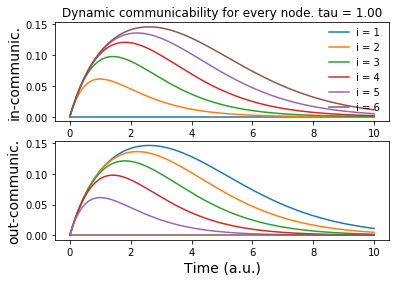

In [17]:
# Calculate the in-/out- dynamic communicability for every node
# indyncom and outdyncom are two arrays of shape (N,nsteps)
indyncom_dir, outdyncom_dir = ndf.NodeEvolution(dyncom_dir)

# Plot the input and output dynamic communicability of every node
pp.figure()
pp.subplot(2,1,1)
pp.title('Dynamic communicability for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    pp.plot(tpoints, indyncom_dir[:,i], label='i = %d' %(i+1))
pp.ylabel('in-communic.', fontsize=14)
pp.legend(frameon=False)

pp.subplot(2,1,2)
for i in range(N):
    pp.plot(tpoints, outdyncom_dir[:,i], label='i = %d' %(i+1))
pp.ylabel('out-communic.', fontsize=14)
pp.xlabel('Time (a.u.)', fontsize=14)

pp.show()

<br/>

We now repeat the study above but chains whose _**links are undirected**_ and follow the same perturbation "protocols" as illustrated below.

<img src="Images/PathGraph_Undirected1.pdf" style="float:center; width:500px; height:50px"  alt="Path Graph" />
<img src="Images/PathGraph_Undirected2.pdf" style="float:center; width:500px; height:50px"  alt="Path Graph" />

In this case, the perturbations can diffuse in both directions. Also, the largest eigenvalue (λmax) of the path graph is finite, thus imposing a limitation to the largest τ time-constant. The condition **τmax < 1 / λmax** needs to be satisfied for the system to be convergent. Otherwise, if τmax > 1 / λmax, then leakage of "energy" at the nodes is insufficient to counterbalance the "energy" generated at the links, thus making the system diverge or explode.



In [18]:
# Create the undirected path graph of N = 6 nodes
N = 6
undnet = galib.models.PathGraph(N, directed=False)

# Find the spectral radius and the largest time constant 
evs = numpy.linalg.eigvals(undnet)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:', evmax )
print( 'Largest possible tau:', maxtau)

Spectral radius: 1.8019377358048398
Largest possible tau: 0.5549581320873707


In [19]:
# Set the matrix of noisy inputs
sigma = np.zeros((N,N), np.float)
sigma[0,0] = 1.0
# Set a time-constant
tau = 0.45

# Define the temporal resolution
tfinal = 10
dt = 0.01
tpoints = np.arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the dynamic flow for a time span between 0 and tmax
dynflow_und = ndf.DynFlow(undnet, tau, sigma, tmax=tfinal, timestep=dt, normed=True)
# Calculate the dynamic communicability for a time span between 0 and tmax
dyncom_und = ndf.DynCom(undnet, tau, tmax=tfinal, timestep=dt, normed=True)

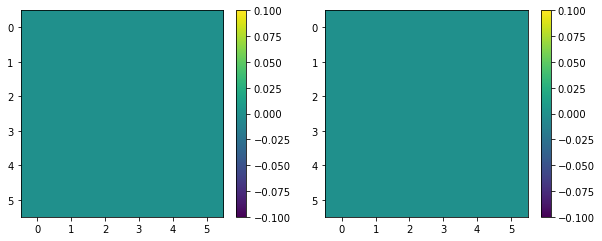

In [20]:
# Visualise the dynamic communicability matrices at different times
pp.figure(figsize=(10,3.8))
# Check for (temporal) indices: 0, 100, 200, 400, 600, 800
tidx = 0

# Plot the flow matrix
pp.subplot(1,2,1)
pp.imshow(dynflow_und[tidx], aspect='auto')
pp.colorbar()

# Plot the flow matrix
pp.subplot(1,2,2)
pp.imshow(dyncom_und[tidx], aspect='auto')
pp.colorbar()

#pp.tight_layout()
pp.show()

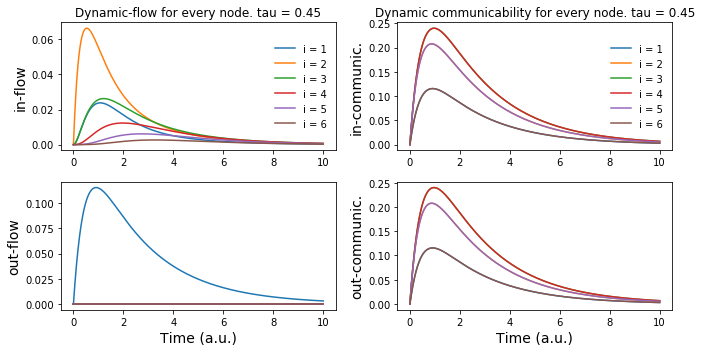

In [21]:
# Calculate the in-/out- dynamic flow and communicability for every node
inflow_und, outflow_und = ndf.NodeEvolution(dynflow_und)
indyncom_und, outdyncom_und = ndf.NodeEvolution(dyncom_und)


# Plot the input and output results for every node
pp.figure(figsize=(10,5))
# Plot the results for the in-/out-flow
pp.subplot(2,2,1)
pp.title('Dynamic-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    pp.plot(tpoints, inflow_und[:,i], label='i = %d' %(i+1))
#pp.ylim(-0.005,0.1)
pp.ylabel('in-flow', fontsize=14)
pp.legend(loc='center right', frameon=False)

pp.subplot(2,2,3)
for i in range(N):
    pp.plot(tpoints, outflow_und[:,i], label='i = %d' %(i+1))
pp.ylabel('out-flow', fontsize=14)
pp.xlabel('Time (a.u.)', fontsize=14)

# Plot the results for the in-/out-dynamic communicability
pp.subplot(2,2,2)
pp.title('Dynamic communicability for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    pp.plot(tpoints, indyncom_und[:,i], label='i = %d' %(i+1))
pp.ylabel('in-communic.', fontsize=14)
pp.legend(loc='center right', frameon=False)

pp.subplot(2,2,4)
for i in range(N):
    pp.plot(tpoints, outdyncom_und[:,i], label='i = %d' %(i+1))
pp.ylabel('out-communic.', fontsize=14)
pp.xlabel('Time (a.u.)', fontsize=14)

pp.tight_layout()
pp.show()

<br/>

## Part 3:  Ring lattices and comparison with other benchmarks

As a second example, we consider a network with xxx same notion of neighborhood, where node *i* is close to nodes *i-1* and *i+1* (note that indices *0* and *N-1* are also neighbors).

Here the global feedback is related to *c_0* and the heterogeneity of the weights is controlled by *w_spread* (homogeneous weights for *w_spread = 0*).

Setting *N = 4* nodes and *n = 1* reproduces parts of Fig. 2 and 3 in the paper:  Gilson M, Kouvaris NE, Deco G, Zamora-López G (2018) Phys Rev E, https://doi.org/10.1103/PhysRevE.97.052301.

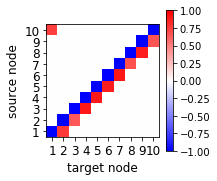

In [22]:
# network properties
N = 10 # number of nodes

tau = 1. # time constant (for exponential decay)

c0 = 0.8 # average weight per node (global scaling factor)
w_spread = 0.2 # spread of weights

# create random connectivity matrix
C = np.zeros([N,N])
for i in range(N):
    C[i-1,i] = c0 * (1+2*w_spread*(np.random.rand()-0.5)) # connection from i-1 to i
    
# range of integration time
T = 20. # duration
dt = 0.5 # time step
vT = np.arange(0,T+dt*0.5,dt) # discrete simulation steps
nT = vT.size

# calculate dynamic communicability
dc =  ndf.DynCom(C, tau, tmax=T, timestep=dt)

# plot Jacobian
J = -np.eye(N) / tau + C

pp.figure(figsize=[3,3])
pp.axes([0.2,0.25,0.65,0.65])
pp.imshow(J,origin='lower',interpolation='nearest',vmin=-1,vmax=1,cmap='bwr')
pp.xticks(range(N),np.arange(N)+1,fontsize=12)
pp.yticks(range(N),np.arange(N)+1,fontsize=12)
pp.colorbar()
pp.xlabel('target node',fontsize=12)
pp.ylabel('source node',fontsize=12)

pp.show()

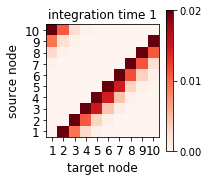

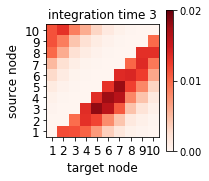

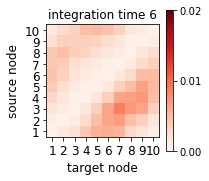

In [23]:
# communicability matrix at 3 integration times
for t in [1,3,6]:
    pp.figure(figsize=[3,3])
    pp.axes([0.2,0.25,0.65,0.65])
    pp.imshow(dc[int(t/dt)],origin='lower',interpolation='nearest',vmin=0,vmax=0.02,cmap='Reds')
    pp.xticks(range(N),np.arange(N)+1,fontsize=12)
    pp.yticks(range(N),np.arange(N)+1,fontsize=12)
    pp.colorbar(ticks=[0,0.01,0.02])
    pp.xlabel('target node',fontsize=12)
    pp.ylabel('source node',fontsize=12)
    pp.title('integration time '+str(t),fontsize=12)


Total communicability is a time-dependent measure that sums all interactions bewteen pairs of nodes. It is related to the global network feedback, related to *c_0* here.

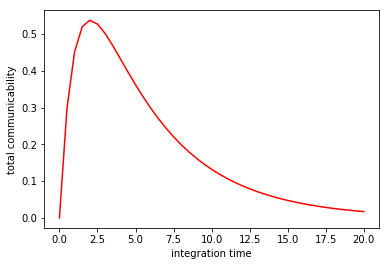

In [24]:
pp.figure()
pp.plot(vT, ndf.TotalEvolution(dc), c='r')
pp.xlabel('integration time')
pp.ylabel('total communicability')

pp.show()

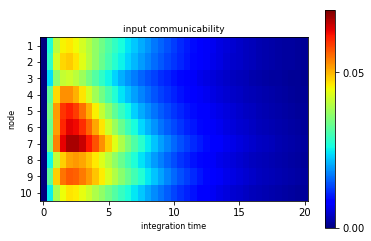

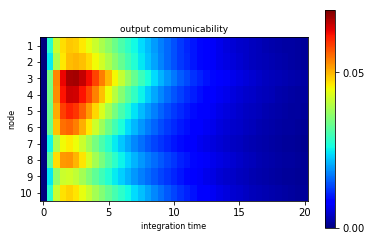

In [25]:
# evolution over time of sum of incoming/outgoing EC-based dynamic communicability for all nodes
in_dc, out_dc = ndf.NodeEvolution(dc)

# integration time to plot (rescaled by dt)
vT_aff = np.array([0,10,20,30,40])
vT_aff_lbl = np.array(vT_aff*dt, dtype=np.int)

pp.figure()
pp.imshow(in_dc.T, vmin=0, vmax=0.07, aspect=2.5, cmap='jet')
pp.xticks(vT_aff, vT_aff_lbl)
pp.yticks(range(N), np.arange(N)+1)
pp.xlabel('integration time',fontsize=8)
pp.ylabel('node',fontsize=8)
pp.colorbar(ticks=[0,0.05])
pp.title('input communicability',fontsize=9)

pp.figure()
pp.imshow(out_dc.T, vmin=0, vmax=0.07, aspect=2.5, cmap='jet')
pp.xticks(vT_aff, vT_aff_lbl)
pp.yticks(range(N), np.arange(N)+1)
pp.xlabel('integration time',fontsize=8)
pp.ylabel('node',fontsize=8)
pp.colorbar(ticks=[0,0.05])
pp.title('output communicability',fontsize=9)

pp.show()

Communicability interactions are first aligned with the weights in the connectivity matrix. Then, for increasing integration times, they evolve to eventually become homogeneous.

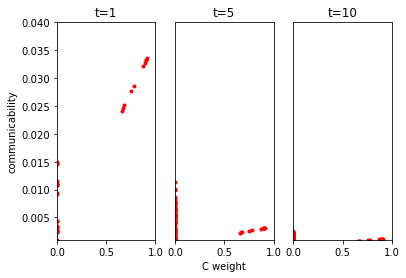

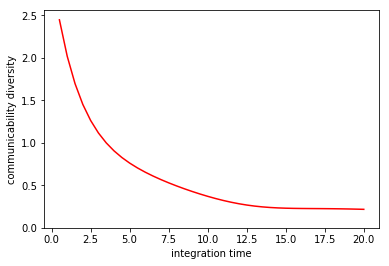

In [26]:
# comparison between communicability and EC matrices over time
pp.figure()
for i, t in enumerate([1,5,10]):
    pp.subplot(1,3,i+1)
    pp.plot(C, dc[int(t/dt)], '.r')
    if i==1:
        pp.xlabel('C weight')
    if i==0:
        pp.ylabel('communicability')
    else:
        pp.yticks([])
    pp.axis(xmin=-0.001, xmax=1, ymin=0.001, ymax=0.04)
    pp.title('t='+str(t))

pp.figure()
pp.plot(vT, ndf.Diversity(dc), color='r')
pp.axis(ymin=0)
pp.xlabel('integration time')
pp.ylabel('communicability diversity')
    
pp.show()

### Comparison with symmetric network

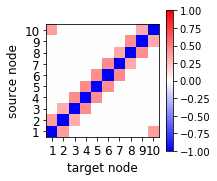

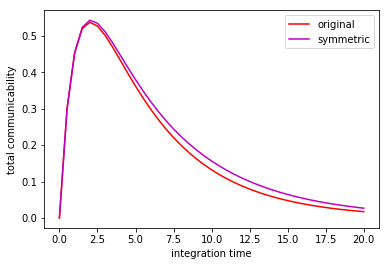

In [27]:
# symmetric version of the original C
C_sym = 0.5 * (C + C.T)

# dynamic communicability for symmetric network
dc_sym =  ndf.DynCom(C_sym, tau, tmax=T, timestep=dt)

# symmetric Jacobian
J_sym = -np.eye(N) / tau + C_sym

pp.figure(figsize=[3,3])
pp.axes([0.2,0.25,0.65,0.65])
pp.imshow(J_sym,origin='lower',interpolation='nearest',vmin=-1,vmax=1,cmap='bwr')
pp.xticks(range(N),np.arange(N)+1,fontsize=12)
pp.yticks(range(N),np.arange(N)+1,fontsize=12)
pp.colorbar()
pp.xlabel('target node',fontsize=12)
pp.ylabel('source node',fontsize=12)

# comparison of total communicability for the symmetric and the original connectivities

pp.figure()
pp.plot(vT, ndf.TotalEvolution(dc), c='r')
pp.plot(vT, ndf.TotalEvolution(dc_sym), c='m')
pp.legend(['original','symmetric'])
pp.xlabel('integration time')
pp.ylabel('total communicability')

pp.show()

### Comparison with open loop

Now we remove a connection and redistribute its value to other nodes, keeping the total weight constant. The obtaine dopen loop has a much smaller total communicability.

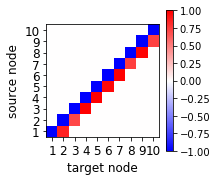

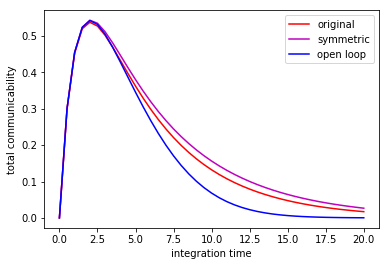

In [28]:
C_open = np.copy(C)
C_open[-1,0] = 0
C_open *= C.sum() / C_open.sum()

# calculate dynamic communicability
dc_open =  ndf.DynCom(C_open, tau, tmax=T, timestep=dt)

# rewired Jacobian
J_open = -np.eye(N) / tau + C_open

pp.figure(figsize=[3,3])
pp.axes([0.2,0.25,0.65,0.65])
pp.imshow(J_open,origin='lower',interpolation='nearest',vmin=-1,vmax=1,cmap='bwr')
pp.xticks(range(N),np.arange(N)+1,fontsize=12)
pp.yticks(range(N),np.arange(N)+1,fontsize=12)
pp.colorbar()
pp.xlabel('target node',fontsize=12)
pp.ylabel('source node',fontsize=12)

# comparison of total communicability for the 3 configurations

pp.figure()
pp.plot(vT, ndf.TotalEvolution(dc), c='r')
pp.plot(vT, ndf.TotalEvolution(dc_sym), c='m')
pp.plot(vT, ndf.TotalEvolution(dc_open), c='b')
pp.legend(['original','symmetric','open loop'])
pp.xlabel('integration time')
pp.ylabel('total communicability')

pp.show()

### Comparison with rewired network

Now we rewire the network some of the existing connections to random nodes.

The outcome may be an decrease of total communicability when the rewiring leads to an open loop or increased total communicability when it yields clusters of strongly connected nodes (with several closed loops).

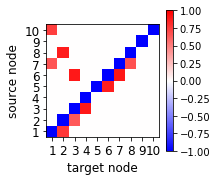

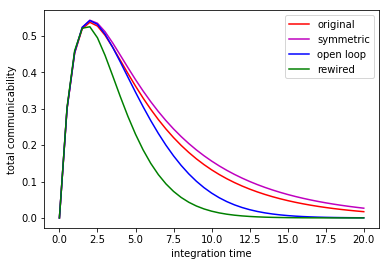

In [29]:
p_rew = 0.3 # probability of rewiring (random network with p_rew=1)

# rewiring C with probability p_rew for each existing connection
C_rew = np.zeros(C.shape)
for i in range(N):
    for j in range(N):
        if C[i,j]>0:
            if np.random.rand()<p_rew:
                i_rew = np.random.randint(N)
                j_rew = np.random.randint(N)
                while j_rew==i_rew:
                    j_rew = np.random.randint(N)
                C_rew[i_rew,j_rew] += C[i,j]
            else:
                C_rew[i,j] += C[i,j]

# calculate dynamic communicability
dc_rew =  ndf.DynCom(C_rew, tau, tmax=T, timestep=dt)

# rewired Jacobian
J_rew = -np.eye(N) / tau + C_rew

pp.figure(figsize=[3,3])
pp.axes([0.2,0.25,0.65,0.65])
pp.imshow(J_rew,origin='lower',interpolation='nearest',vmin=-1,vmax=1,cmap='bwr')
pp.xticks(range(N),np.arange(N)+1,fontsize=12)
pp.yticks(range(N),np.arange(N)+1,fontsize=12)
pp.colorbar()
pp.xlabel('target node',fontsize=12)
pp.ylabel('source node',fontsize=12)

# comparison of total communicability for the 3 configurations

pp.figure()
pp.plot(vT, ndf.TotalEvolution(dc), c='r')
pp.plot(vT, ndf.TotalEvolution(dc_sym), c='m')
pp.plot(vT, ndf.TotalEvolution(dc_open), c='b')
pp.plot(vT, ndf.TotalEvolution(dc_rew), c='g')
pp.legend(['original','symmetric','open loop','rewired'])
pp.xlabel('integration time')
pp.ylabel('total communicability')

pp.show()

### Comparison with ring lattice connected up to several neighbors

Now we come back to the original ring network and replace the single connection with the preceeding neighbor by several connections with the preceeding neighbors. This gives the same total communicability, but gives faster homogenization of the interactions between the nodes, which is reflected in the diversity.

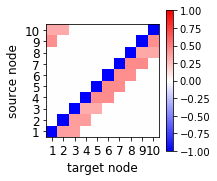

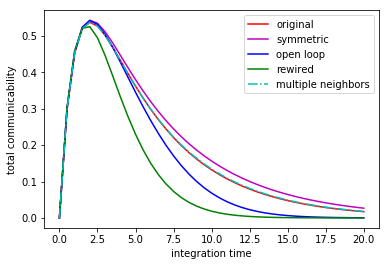

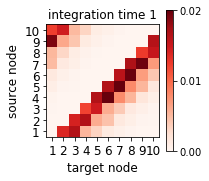

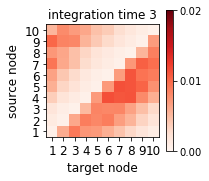

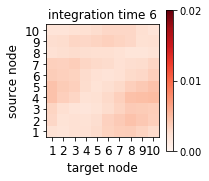

In [30]:
n = 2 # number of neighbors to connect (preceeding neighbors in the index order)

# create random connectivity matrix
C_n = np.zeros([N,N])
for j in range(N): # target node
    for i in range(j-n,j): # preceeding neighbors
        C_n[i,j] = C[i-1,i] / n # connection from i to j

# calculate dynamic communicability
dc_n =  ndf.DynCom(C_n, tau, tmax=T, timestep=dt)

# Jacobian
J_n = -np.eye(N) / tau + C_n

pp.figure(figsize=[3,3])
pp.axes([0.2,0.25,0.65,0.65])
pp.imshow(J_n,origin='lower',interpolation='nearest',vmin=-1,vmax=1,cmap='bwr')
pp.xticks(range(N),np.arange(N)+1,fontsize=12)
pp.yticks(range(N),np.arange(N)+1,fontsize=12)
pp.colorbar()
pp.xlabel('target node',fontsize=12)
pp.ylabel('source node',fontsize=12)

# comparison of total communicability for the 3 configurations
pp.figure()
pp.plot(vT, ndf.TotalEvolution(dc), c='r')
pp.plot(vT, ndf.TotalEvolution(dc_sym), c='m')
pp.plot(vT, ndf.TotalEvolution(dc_open), c='b')
pp.plot(vT, ndf.TotalEvolution(dc_rew), c='g')
pp.plot(vT, ndf.TotalEvolution(dc_n), c='c', ls='-.')
pp.legend(['original','symmetric','open loop','rewired','multiple neighbors'])
pp.xlabel('integration time')
pp.ylabel('total communicability')

# communicability matrix at 3 integration times
for t in [1,3,6]:
    pp.figure(figsize=[3,3])
    pp.axes([0.2,0.25,0.65,0.65])
    pp.imshow(dc_n[int(t/dt)],origin='lower',interpolation='nearest',vmin=0,vmax=0.02,cmap='Reds')
    pp.xticks(range(N),np.arange(N)+1,fontsize=12)
    pp.yticks(range(N),np.arange(N)+1,fontsize=12)
    pp.colorbar(ticks=[0,0.01,0.02])
    pp.xlabel('target node',fontsize=12)
    pp.ylabel('source node',fontsize=12)
    pp.title('integration time '+str(t),fontsize=12)

pp.show()

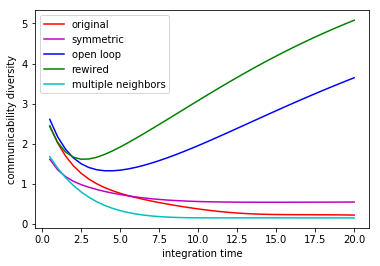

In [31]:
# diversity
pp.figure()
pp.plot(vT, ndf.Diversity(dc), c='r')
pp.plot(vT, ndf.Diversity(dc_sym), c='m')
pp.plot(vT, ndf.Diversity(dc_open), c='b')
pp.plot(vT, ndf.Diversity(dc_rew), c='g')
pp.plot(vT, ndf.Diversity(dc_n), c='c')
pp.legend(['original','symmetric','open loop','rewired','multiple neighbors'])
pp.xlabel('integration time')
pp.ylabel('communicability diversity')

pp.show()

Interestingly, the homogenization is quicker for the unidirectional loop with 2 neighbors than the symmetric loop, which also has two neighbors. This comes from the fact that the activity at a given node affect more distant nodes in the former configuration.

Note that diversity diverges for the open loop, which comes from the fact that the mean of the communicability interactions decreases too quickly over time.